In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline
%load_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
#import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_probability
tfd = tensorflow_probability.distributions
import tensorflow_probability as tfp
tfb = tfp.bijectors
slim = tf.contrib.slim
from tensorflow.python.framework import constant_op
from tensorflow.python.ops import gradients_impl



import tensorflow_hub as hub
tfd = tensorflow_probability.distributions
tfd = tfp.distributions
tfb = tfp.bijectors


# tf.enable_eager_execution()

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
# path = '/data2/cosmo4d/'
path = '../data/z00//'

ftype = 'L%04d_N%04d_S%04d_%02dstep/'
ftypefpm = 'L%04d_N%04d_S%04d_%02dstep_fpm/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200, 300, 400]
seeds = [100]


# Training data set

In [6]:
cube_sizes = np.array([16, 32, 64, 128])
num_cubes= 500#(500*8/cube_sizes).astype('int')
pad = 0
cube_sizesft = cube_sizes + 2*pad
max_offset = ncp - cube_sizes
ftname = ['cic']
tgname = ['pnn']
nchannels = len(ftname)
rprob = 0.5

In [7]:
   
#############################
##Read data and generate meshes
meshes = {}
cube_features, cube_target = [[] for i in range(len(cube_sizes))], [[] for i in range(len(cube_sizes))]

for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftypefpm%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, 10, kny)                                                                                                                                                                                                                                

    hmesh = {}
    ##Uncomment for galaxies
#     hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
#     hposd = tools.readbigfile(hpath + 'Position/')
#     massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)*1e10
#     galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
#     hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
#     hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)
#     hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
#     targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]    
    hposd = hposall[:num].copy()
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['pcic'] = tools.paintcic(hposd, bs, ncp)
    massall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/Mass/')[1:]    
    massd = massall[:num].copy().reshape(-1)*1e10
    hmesh['mnn'] = tools.paintnn(hposd, bs, ncp, massd)
    hmesh['lmnn'] = np.log(1+hmesh['mnn'])
    targetmesh = [hmesh[tgname[0]]]

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    ntarget = len(targetmesh)

    for i, size in enumerate(cube_sizes):
        print('For size = ', size)
        if size==nc:
            features = [np.stack(ftlistpad, axis=-1)]
            target = [np.stack(targetmesh, axis=-1)]
        else:
            numcubes = int(num_cubes/size*4)
            features, target = dtools.randomvoxels(ftlistpad, targetmesh, numcubes, max_offset[i],
                                            size, cube_sizesft[i], seed=seed, rprob=0)
        cube_features[i] = cube_features[i] + features
        cube_target[i] = cube_target[i] + target

# #
for i in range(cube_sizes.size):
    cube_target[i] = np.stack(cube_target[i],axis=0)
    cube_features[i] = np.stack(cube_features[i],axis=0)
    print(cube_features[i].shape, cube_target[i].shape)

    


All the mesh have been generated for seed = 100
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
For size =  128
(125, 16, 16, 16, 1) (125, 16, 16, 16, 1)
(62, 32, 32, 32, 1) (62, 32, 32, 32, 1)
(31, 64, 64, 64, 1) (31, 64, 64, 64, 1)
(1, 128, 128, 128, 1) (1, 128, 128, 128, 1)


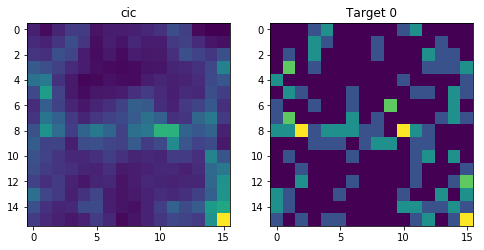

In [8]:
fig, ax = plt.subplots(1, nchannels+ntarget, figsize = (nchannels*4+4, 5))
n = 10
for i in range(nchannels):
    ax[i].imshow(cube_features[0][n][:,:,:,i].sum(axis=0))
    ax[i].set_title(ftname[i])
for j in range(ntarget):
    ax[i+j+1].imshow(cube_target[0][n][:,:,:,j].sum(axis=0))
    ax[i+j+1].set_title('Target %d'%j)
# ax[-1].imshow(cube_target[n][:,:,:,0].sum(axis=0))
# ax[-1].set_title('Target')

In [9]:
cube_target[0].max()

4.0

# Model

In [200]:
  

class Squeeze3d(tfb.Reshape):
    """
    Borrowed from https://github.com/openai/glow/blob/master/tfops.py
    """
    
    def __init__(self,
                 event_shape_in,
                 factor=2,
                 is_constant_jacobian=True,
                 validate_args=False,
                 name=None):

        assert factor >= 1
        name = name or "squeeze"
        self.factor = factor
        event_shape_out = 1*event_shape_in
        event_shape_out[0] //=2
        event_shape_out[1] //=2
        event_shape_out[2] //=2
        event_shape_out[3] *=8
        self.event_shape_out = event_shape_out
        
        super(Squeeze3d, self).__init__(
            event_shape_out=event_shape_out,
            event_shape_in=event_shape_in,
        validate_args=validate_args,
        name=name)
    
    def _forward(self, x):        
        if self.factor == 1:
            return x
        factor = self.factor

        shape = tf.shape(x)
        height = shape[1]
        width = shape[2]
        length = shape[3]
        n_channels = x.get_shape()[4]

#         print(height, width, length, n_channels )
#         assert height % factor == 0 and width % factor == 0 and length % factor == 0
        x = tf.reshape(x, [-1, height//factor, factor,
                           width//factor, factor, length//factor, factor, n_channels])
        x = tf.transpose(x, [0, 1, 3, 5, 7, 2, 4, 6])
        x = tf.reshape(x, [-1, height//factor, width//factor, 
                               length//factor, n_channels*factor**3])
        return x
    
    def _inverse(self, x):        
        if self.factor == 1:
            return x
        factor = self.factor

        shape = tf.shape(x)
        height = shape[1]
        width = shape[2]
        length = shape[3]
        n_channels = int(x.get_shape()[4])
        
#         print(height, width, length, n_channels )
        assert n_channels >= 8 and n_channels % 8 == 0
        x = tf.reshape(
            x, [-1, height, width, length, int(n_channels/factor**3), factor, factor, factor])
        x = tf.transpose(x, [0, 1, 5, 2, 6, 3, 7, 4])
        x = tf.reshape(x, (-1, height*factor,
                           width*factor, height*factor, int(n_channels/factor**3)))
        return x
    

    


In [201]:
# n = 4
# tmp = tf.constant(np.arange(n**3).reshape(1, n, n, n, 1))
# sq = Squeeze3d([n, n, n, 1])
# tmp2 = sq.forward(tmp)
# tmp2.shape
# tmp3 = sq.inverse(tmp2)
# tmp3 - tmp

In [202]:

from layers import wide_resnet
h = 0.1


class iRevNetsimple(tfb.Bijector):

    def __init__(self,
       h=0.1,
       is_constant_jacobian=True,
       validate_args=False,
       name=None, kernel_size=3):
        self.h = h
        self.kernel_size = kernel_size
        name = name or "revnet"
        super(iRevNetsimple, self).__init__(
        forward_min_event_ndims=3,
        is_constant_jacobian=is_constant_jacobian,
        validate_args=validate_args,
        name=name)
        
    def _forward(self, x):
        # Split the input in half
        x1, x2 = tf.split(x, num_or_size_splits=2, axis=-1)
        fx2 = tf.layers.conv3d(x2, x2.shape[-1], self.kernel_size,  strides=1, #training=True, 
                          name=self.name+'/bottle', 
                               reuse=tf.AUTO_REUSE, padding='same' )
#         fx2 = wide_resnet(x2, x2.shape[-1],  #training=True, 
#                           scope=self.name+'/bottle')
#         fx2 = tf.identity(x2)
        y1 = x1 + self.h*fx2
        return tf.concat([x2, y1], axis=-1)
    
    def _inverse(self, x, kernel_size=3):
        x2, y1 = tf.split(x, num_or_size_splits=2, axis=-1)
        Fx2 = - self.h*tf.layers.conv3d(x2, x2.shape[-1], self.kernel_size, strides=1, #training=True, 
                                   name=self.name+'/bottle', 
                                        reuse=tf.AUTO_REUSE , padding='same' )
#         Fx2 = - self.h*wide_resnet(x2, x2.shape[-1], scope=self.name+'/bottle', )
        x1 = Fx2 + y1
        return tf.concat([x1, x2], axis=-1)

    def _inverse_log_det_jacobian(self, y):
        return constant_op.constant(0., x.dtype.base_dtype)

    def _forward_log_det_jacobian(self, x):     
        return constant_op.constant(0., x.dtype.base_dtype)
    
    
    

In [203]:

from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops.losses import losses

def wasserstein_gradient_penalty(
    real_data,
    generated_data,
    generator_inputs,
    discriminator_fn,
    discriminator_scope,
    epsilon=1e-10,
    target=1.0,
    one_sided=False,
    weights=1.0,
    scope=None,
    loss_collection=ops.GraphKeys.LOSSES,
    reduction=losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
    add_summaries=False):
  """The gradient penalty for the Wasserstein discriminator loss.
  See `Improved Training of Wasserstein GANs`
  (https://arxiv.org/abs/1704.00028) for more details.
  Args:
    real_data: Real data.
    generated_data: Output of the generator.
    generator_inputs: Exact argument to pass to the generator, which is used
      as optional conditioning to the discriminator.
    discriminator_fn: A discriminator function that conforms to TF-GAN API.
    discriminator_scope: If not `None`, reuse discriminators from this scope.
    epsilon: A small positive number added for numerical stability when
      computing the gradient norm.
    target: Optional Python number or `Tensor` indicating the target value of
      gradient norm. Defaults to 1.0.
    one_sided: If `True`, penalty proposed in https://arxiv.org/abs/1709.08894
      is used. Defaults to `False`.
    weights: Optional `Tensor` whose rank is either 0, or the same rank as
      `real_data` and `generated_data`, and must be broadcastable to
      them (i.e., all dimensions must be either `1`, or the same as the
      corresponding dimension).
    scope: The scope for the operations performed in computing the loss.
    loss_collection: collection to which this loss will be added.
    reduction: A `tf.losses.Reduction` to apply to loss.
    add_summaries: Whether or not to add summaries for the loss.
    A loss Tensor. The shape depends on `reduction`.
  Raises:
    ValueError: If the rank of data Tensors is unknown.
  """
  with ops.name_scope(scope, 'wasserstein_gradient_penalty',
                      (real_data, generated_data)) as scope:
    real_data = ops.convert_to_tensor(real_data)
    generated_data = ops.convert_to_tensor(generated_data)
    if real_data.shape.ndims is None:
      raise ValueError('`real_data` can\'t have unknown rank.')
    if generated_data.shape.ndims is None:
      raise ValueError('`generated_data` can\'t have unknown rank.')

    differences = generated_data - real_data
    batch_size = differences.shape.dims[0].value or array_ops.shape(
        differences)[0]
    alpha_shape = [batch_size] + [1] * (differences.shape.ndims - 1)
    alpha = random_ops.random_uniform(shape=alpha_shape)
    interpolates = real_data + (alpha * differences)

#     with ops.name_scope(None):  # Clear scope so update ops are added properly.
#       # Reuse variables if variables already exists.
#       with variable_scope.variable_scope(discriminator_scope, 'gpenalty_dscope',
#                                          reuse=variable_scope.AUTO_REUSE):
# #         disc_interpolates = discriminator_fn(interpolates, generator_inputs)
#         disc_interpolates = discriminator_fn(interpolates)
    disc_interpolates = discriminator_fn(interpolates)

    if isinstance(disc_interpolates, tuple):
      # ACGAN case: disc outputs more than one tensor
      disc_interpolates = disc_interpolates[0]

    gradients = gradients_impl.gradients(disc_interpolates, interpolates)[0]
    gradient_squares = math_ops.reduce_sum(
        math_ops.square(gradients), axis=list(range(1, gradients.shape.ndims)))
    # Propagate shape information, if possible.
    if isinstance(batch_size, int):
      gradient_squares.set_shape([
          batch_size] + gradient_squares.shape.as_list()[1:])
    # For numerical stability, add epsilon to the sum before taking the square
    # root. Note tf.norm does not add epsilon.
    slopes = math_ops.sqrt(gradient_squares + epsilon)
    penalties = slopes / target - 1.0
    if one_sided:
      penalties = math_ops.maximum(0., penalties)
    penalties_squared = math_ops.square(penalties)
#     penalty = losses.compute_weighted_loss(
#         penalties_squared, weights, scope=scope,
#         loss_collection=loss_collection, reduction=reduction)
    penalty = penalties_squared

    if add_summaries:
      summary.scalar('gradient_penalty_loss', penalty)

    return penalty
    
    
    


In [240]:
softplus = False
loss = 'l2'

# def _mdn_model_fn(features, labels, n_y, n_mixture, cube_size, dropout, optimizer, mode):
def _mdn_model_fn(features, labels, n_y, nchannels, dropout, optimizer, mode, ):

    # Check for training mode
    is_training = mode == tf.estimator.ModeKeys.TRAIN
        
    def _module_fn():
        """
        Function building the module
        """
    
        feature_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
        obs_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, n_y], name='observations')
        shift = tf.Variable(1., dtype=tf.float32, name='shift')
        scale = tf.Variable(1., dtype=tf.float32, name='scale')
        # Builds the neural network
        # ! ny and nchannel need to be the same

        cube_size = tf.shape(feature_layer)[1]
        batch_size = tf.shape(feature_layer)[0]
#         print(cube_size)
        chain = tfb.Chain([tfp.bijectors.Affine(shift=shift, scale_identity_multiplier=scale), 
                    tfb.Invert(Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, nchannels])),
                   iRevNetsimple(name='layer1',h=h),
                   iRevNetsimple(name='layer1b',h=h),
                   iRevNetsimple(name='layer2',h=h),
                   iRevNetsimple(name='layer2b',h=h),
                   tfb.Permute(arange(8)[::-1],axis=-1),
                   iRevNetsimple(name='layer3',h=h),
                   iRevNetsimple(name='layer3b',h=h),
                   iRevNetsimple(name='layer4',h=h),
                   iRevNetsimple(name='layer4b',h=h),
                   tfb.Invert(Squeeze3d(event_shape_in=[cube_size//2,cube_size//2,cube_size//2,nchannels*8])), 
                   iRevNetsimple(name='layer5',h=h),
                   iRevNetsimple(name='layer5b',h=h),
                   iRevNetsimple(name='layer6',h=h),
                   iRevNetsimple(name='layer6b',h=h),
                   tfb.Permute(arange(64)[::-1],axis=-1),
                   iRevNetsimple(name='layer15',h=h),
                   iRevNetsimple(name='layer15b',h=h),
                   iRevNetsimple(name='layer16',h=h),
                   iRevNetsimple(name='layer16b',h=h),
                   Squeeze3d(event_shape_in=[cube_size//2,cube_size//2,cube_size//2,nchannels*8]), 
                   iRevNetsimple(name='layer17',h=h),
                   iRevNetsimple(name='layer17b',h=h),
                   iRevNetsimple(name='layer18',h=h),
                   iRevNetsimple(name='layer18b',h=h),
                   tfb.Permute(arange(8)[::-1],axis=-1),
                   iRevNetsimple(name='layer19',h=h),
                   iRevNetsimple(name='layer19b',h=h),
                   iRevNetsimple(name='layer20',h=h),
                   iRevNetsimple(name='layer20b',h=h),
                   Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, nchannels])])

        bijection = chain
        

        net = bijection.forward(feature_layer, name='lambda')
        backnet = bijection.inverse(obs_layer)
        
        #Forward lipschitz
        alpha = 1.
        mean, var = tf.nn.moments(feature_layer, axes=-1)
        shape = [batch_size, cube_size, cube_size, cube_size, int(nchannels)]

        fwdnoise = tf.random_normal(shape, mean=0, stddev=1)
        finterpolates = feature_layer + alpha*fwdnoise
        #finterpolates = feature_layer + alpha*backnet
        
        fwd_interpolates = bijection.forward(finterpolates)
        gradients = gradients_impl.gradients(fwd_interpolates, finterpolates)[0]
        gradient_squares = math_ops.reduce_sum(
            math_ops.square(gradients), axis=list(range(1, gradients.shape.ndims)))

        slopes = math_ops.sqrt(gradient_squares + 1e-10)
        penalties = slopes / 1.0 - 1.0
        penalties_squared = math_ops.square(penalties)
        lips_fwd_loss = penalties_squared

        #Backward lipschitz
        alpha = 0.1
        mean, var = tf.nn.moments(net, axes=-1)
        shape = [batch_size, cube_size, cube_size, cube_size, n_y]
        bwdnoise = tf.random_normal(shape, mean=0, stddev=1)
#         binterpolates = net + alpha*bwdnoise
        #binterpolates = net + alpha*obs_layer
        binterpolates = net 
        
        bwd_interpolates = bijection.forward(binterpolates)
        gradients = gradients_impl.gradients(bwd_interpolates, binterpolates)[0]
        gradient_squares = math_ops.reduce_sum(
            math_ops.square(gradients), axis=list(range(1, gradients.shape.ndims)))
        
        slopes = math_ops.sqrt(gradient_squares + 1e-10)
        penalties = slopes / 1.0 - 1.0
        penalties_squared = math_ops.square(penalties)
        lips_backwd_loss = penalties_squared
    

        print('lips forward loss :', lips_fwd_loss)
        print('lips backward loss :', lips_backwd_loss)
        
        if softplus:
            net = tf.nn.softplus(net)
        dist = tfd.Poisson(net+1e-3)

        sample = tf.squeeze(dist.sample())                                                                                                                                                                                                                                             
        loglik = dist.log_prob(obs_layer)

        l2 = tf.reduce_mean(tf.square(tf.subtract(obs_layer, net)))
        l1 = tf.reduce_mean(tf.abs(tf.subtract(obs_layer, net)))
        

        hub.add_signature(inputs={'features':feature_layer, 'labels':obs_layer},
                          outputs={'sample':sample, 'loglikelihood':loglik, 'lambda':net,
                                   'l2':l2, 'l1':l1, 'lipsfwd':lips_fwd_loss, 'lipsbackwd':lips_backwd_loss})
    

    # Create model and register module if necessary                                                                                                                                                                                                                                       
    spec = hub.create_module_spec(_module_fn)
    module = hub.Module(spec, trainable=True)
    if isinstance(features,dict):
        predictions = module(features, as_dict=True)
    else:
        predictions = module({'features':features, 'labels':labels}, as_dict=True)

    if mode == tf.estimator.ModeKeys.PREDICT:
        hub.register_module_for_export(module, "likelihood")
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)


    if loss == 'loglikelihood':
         loglik = predictions['loglikelihood']
         neg_log_likelihood = -tf.reduce_sum(loglik, axis=-1)
         neg_log_likelihood = tf.reduce_mean(neg_log_likelihood)

    elif loss == 'l2':
        neg_log_likelihood = predictions['l2']
    elif loss == 'l1':
        neg_log_likelihood = predictions['l1']
    else:
        print('Loss not specified')

    lips_fwd_loss = tf.reduce_mean(predictions['lipsfwd'])
    lips_backwd_loss = tf.reduce_mean(predictions['lipsbackwd'])
    
        
    tf.losses.add_loss(neg_log_likelihood)
    tf.losses.add_loss(lips_fwd_loss)
    tf.losses.add_loss(lips_backwd_loss)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

    train_op = None
    eval_metric_ops = None

    # Define optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer(learning_rate=0.0001).minimize(loss=total_loss,
                                        global_step=tf.train.get_global_step())
        tf.summary.scalar('loss', neg_log_likelihood)
        tf.summary.scalar('lips_forward', lips_fwd_loss)
        tf.summary.scalar('lips_backward', lips_backwd_loss)
    elif mode == tf.estimator.ModeKeys.EVAL:
        
        eval_metric_ops = { "log_p": neg_log_likelihood}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

class MDNEstimator(tf.estimator.Estimator):
    """An estimator for distribution estimation using Mixture Density Networks.
    """

    def __init__(self,
                 n_y,
                 nchannels,
#                  cube_size,
                 optimizer=tf.train.AdamOptimizer,
                 dropout=None,
                 model_dir=None,
                 config=None):
        """Initializes a `MDNEstimator` instance.
        """

        def _model_fn(features, labels, mode):
            return _mdn_model_fn(features, labels, 
                 n_y, nchannels, #cube_size, 
                        dropout, optimizer, mode)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [ ]:

#         lips_fwd_loss = wasserstein_gradient_penalty(real_data = obs_layer,
#                                                      generated_data = net,
#                                                      generator_inputs = None,
#                                                      discriminator_fn = bijection.forward,
#                                                      discriminator_scope=None,
#                                                      epsilon=1e-10,
#                                                      target=1.0,
#                                                      one_sided=False,
#                                                      weights=1.0,
#                                                      scope=None,
#                                                      loss_collection=ops.GraphKeys.LOSSES,
#                                                      reduction=losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
#                                                      add_summaries=False)


In [241]:
batch_size = 32

def mapping_function(inds):
    def extract_batch(inds):

        isize = np.random.choice(len(cube_sizes), 1, replace=True)[0]
        batch = int(batch_size*8/cube_sizes[isize])
        if cube_sizes[isize]==nc : batch = 1
        inds = inds[:batch]
        trainingsize = cube_features[isize].shape[0]
        inds[inds >= trainingsize] =  (inds[inds >= trainingsize])%trainingsize

        features = cube_features[isize][inds].astype('float32')
        targets = cube_target[isize][inds].astype('float32')

        for i in range(batch):
            nrotations=0
            while (np.random.random() < rprob) & (nrotations < 3):
                nrot, ax0, ax1 = np.random.randint(0, 3), *np.random.permutation((0, 1, 2))[:2]
                features[i] = np.rot90(features[i], nrot, (ax0, ax1))
                targets[i] = np.rot90(targets[i], nrot, (ax0, ax1))
                nrotations +=1
#             print(batch, isize, i, nrotations, targets[i].shape, targets.shape)                                                                                                                   
# #         print(inds)                                                                                                                                                         
        return features, targets

    ft, tg = tf.py_func(extract_batch, [inds],
                        [tf.float32, tf.float32])
#     sft = cube_features[isize].shape                                                                                                                                          
#     stg = cube_target[isize].shape                                                                                                                                            
#     ft.set_shape((None,)+sft[1:])                                                                                                                                             
#     tg.set_shape((None,)+stg[1:])                                                                                                                                             
    return ft, tg


def training_input_fn():
    """Serving input fn for training data"""

    dataset = tf.data.Dataset.range(len(np.array(cube_features)[0]))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    dataset = dataset.map(mapping_function)
    dataset = dataset.prefetch(16)
    return dataset


def testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.range(len(cube_features))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_function)
    return dataset

In [242]:
savepath = './models/n10/test_lips/'

run_config = tf.estimator.RunConfig(save_checkpoints_steps = 10000)

model =  MDNEstimator(n_y=ntarget, nchannels=nchannels, dropout=0.95,
                      model_dir=savepath + '/model/', config = run_config)
#                       model_dir='./tmp/galmodel/model0', config = run_config)

INFO:tensorflow:Using config: {'_model_dir': './models/n10/test_lips//model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fda18b0c048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Train

In [243]:
%%bash 

ls './models/n10/test_lips/'

# rm -r './models/n10/test_lips/model/'


In [244]:
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import variable_scope

In [245]:
model.train(training_input_fn, max_steps=100)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Tensor("moments/Squeeze:0", shape=(?, ?, ?, ?), dtype=float32) Tensor("moments/Squeeze_1:0", shape=(?, ?, ?, ?), dtype=float32) [<tf.Tensor 'strided_slice_1:0' shape=() dtype=int32>, <tf.Tensor 'strided_slice:0' shape=() dtype=int32>, <tf.Tensor 'strided_slice:0' shape=() dtype=int32>, <tf.Tensor 'strided_slice:0' shape=() dtype=int32>, 1]
Tensor("random_normal:0", shape=(?, ?, ?, ?, 1), dtype=float32)
Tensor("Add:0", shape=(?, ?, ?, ?, 1), dtype=float32)
gradients =  Tensor("gradients/chain_of_affine_of_invert_squeeze_of_layer1_of_layer1b_of_layer2_of_layer2b_of_permute_of_layer3_of_layer3b_of_layer4_of_layer4b_of_invert_squeeze_of_layer5_of_layer5b_of_layer6_of_layer6b_of_permute_of_layer15_of_layer15b_of_layer16_of_layer16b_of_squeeze_of_layer17_of_layer17b_of_layer18_of_layer18b_of_permute_of_layer19_of_layer19b_of_layer20_of_layer20b_of_squeeze_2/forward/squeeze/forward/Reshape_grad/Reshape:0", shape=(?, ?, ?, ?, 1), dtype=float32)
slopes =  Tensor("Sqrt:0", shape=(?,), dtype=floa

In [247]:
model.get_variable_names()

['beta1_power',
 'beta2_power',
 'global_step',
 'module/layer1/bottle/bias',
 'module/layer1/bottle/bias/Adam',
 'module/layer1/bottle/bias/Adam_1',
 'module/layer1/bottle/kernel',
 'module/layer1/bottle/kernel/Adam',
 'module/layer1/bottle/kernel/Adam_1',
 'module/layer15/bottle/bias',
 'module/layer15/bottle/bias/Adam',
 'module/layer15/bottle/bias/Adam_1',
 'module/layer15/bottle/kernel',
 'module/layer15/bottle/kernel/Adam',
 'module/layer15/bottle/kernel/Adam_1',
 'module/layer15b/bottle/bias',
 'module/layer15b/bottle/bias/Adam',
 'module/layer15b/bottle/bias/Adam_1',
 'module/layer15b/bottle/kernel',
 'module/layer15b/bottle/kernel/Adam',
 'module/layer15b/bottle/kernel/Adam_1',
 'module/layer16/bottle/bias',
 'module/layer16/bottle/bias/Adam',
 'module/layer16/bottle/bias/Adam_1',
 'module/layer16/bottle/kernel',
 'module/layer16/bottle/kernel/Adam',
 'module/layer16/bottle/kernel/Adam_1',
 'module/layer16b/bottle/bias',
 'module/layer16b/bottle/bias/Adam',
 'module/layer16b/b

In [ ]:
features = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
labels = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='observations')
    
exporter = hub.LatestModuleExporter("tf_hub",
        tf.estimator.export.build_raw_serving_input_receiver_fn({'features':features, 'labels':labels},
                                                                   default_batch_size=None))

# exporter.export(model, 'models', model.latest_checkpoint())
modulepath = exporter.export(model, savepath + '/module/', model.latest_checkpoint())
modulepath = modulepath.decode("utf-8")
modulepath

## Testing

In [9]:
loss = 'l2'
tf.reset_default_graph()
# modulepath = '/home/chmodi/Projects/galmodel/code/models/n10/rev_cic_l1/module/1548387387/'
modulepath = '/home/chmodi/Projects/galmodel/notebooks/models/n10/rev-nn-l2/module/1548392154/'

module = hub.Module(modulepath + '/likelihood/')

xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)[loss]
poisson = module(dict(features=xx, labels=yy), as_dict=True)['lambda']

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    features = cube_features[0][5:8].astype('float32')
    targets = cube_target[0][5:8].astype('float32')
    xxm = features
    yym = targets
    print(xxm.shape, yym.shape)
    preds = sess.run(samples, feed_dict={xx:xxm, yy:yym})
    pois = sess.run(poisson, feed_dict={xx:xxm, yy:yym})
    llik = sess.run(loglik, feed_dict={xx:xxm, yy:yym})


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(3, 16, 16, 16, 1) (3, 16, 16, 16, 1)


In [10]:
llik

0.03611056

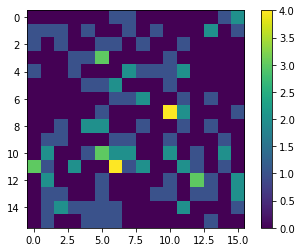

In [12]:
im = imshow(preds[0,:,:,:].sum(axis=-1))
plt.colorbar(im)

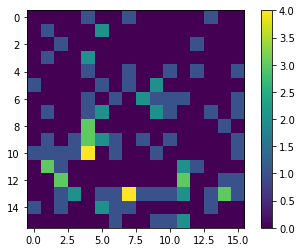

In [13]:
i = imshow(targets[0,:,:,:, 0].sum(axis=-1))
plt.colorbar(im)

In [14]:
cube_target[0].max(), pois.max()

(4.0, 1.3221571)

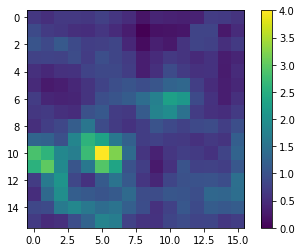

In [15]:
i = imshow(pois[0,:,:,:, 0].sum(axis=-1))
plt.colorbar(im)

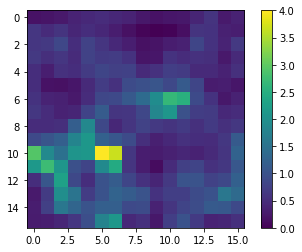

In [16]:
i = imshow(features[0,:,:,:, 0].sum(axis=-1))
plt.colorbar(im)

In [18]:
tf.reset_default_graph()

tf.reset_default_graph()
module = hub.Module(modulepath + '/likelihood')
# module = hub.Module(modulepath + '/likelihood/')

# module = hub.Module('../code/models/galmodel/pad2/module/1546484684/likelihood/')

xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)[loss]
poisson = module(dict(features=xx, labels=yy), as_dict=True)['lambda']

preds = {}
pois = {}
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    for seed in seeds:
        xxm = np.pad(meshes[seed][0]['cic'], pad, 'wrap')
        xxm = np.expand_dims(np.expand_dims(xxm,  -1), 0)

        yym = np.stack([meshes[seed][1]['pnn']], axis=-1)
        yym = np.expand_dims(yym, 0)
        preds[seed] = sess.run(samples, feed_dict={xx:xxm, yy:yym})
        meshes[seed][0]['predict'] = np.squeeze(preds[seed][:, :, :])
        pois[seed] = sess.run(poisson, feed_dict={xx:xxm, yy:yym})
        meshes[seed][0]['lambda'] = np.squeeze(pois[seed][:, :, :])
        print(sess.run(loglik, feed_dict={xx:xxm, yy:yym}))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.030843547
0.030856844
0.031102784
0.03102662


In [ ]:
# meshes[100][0]['lambda']/meshes[100][0]['lambda2']

In [ ]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for seed in seeds:
    key = ''
    predict, hpmeshd = meshes[seed][0]['lambda%s'%key] , meshes[seed][1]['pcic%s'%key], 
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
    ax[1].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0].set_ylabel('Transfer function', fontsize=14)
ax[1].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(1, 2, figsize=(10,5))

key = ''
# predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
predict, hpmeshd = meshes[seed][0]['lambda%s'%key] , meshes[seed][1]['pnn%s'%key], 
vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
im = ax[0].imshow(predict[:, :, :].sum(axis=0), vmin=None, vmax=None)
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=None, vmax=None)
plt.colorbar(im, ax=ax[1])
ax[0].set_ylabel('Prediction', fontsize=15)
ax[1].set_ylabel('Truth', fontsize=15)
plt.show()


In [80]:
predict.max()

3.344097

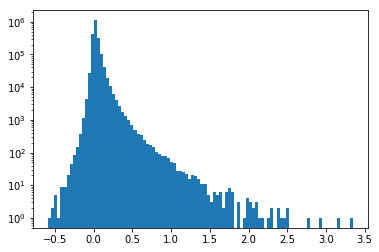

In [81]:
plt.hist(predict.flatten(), bins=100, log=True)
plt.show()

In [82]:
x = np.linspace(0, 10, 1000)
y = 5.21*x + 0.463
ys = y + np.random.normal(0, 0.1, 1000)

tf.reset_default_graph()


xx = tf.placeholder(tf.float32, shape=[None], name='input')
yy = tf.placeholder(tf.float32, shape=[None], name='input')
shift = tf.Variable(1., dtype=tf.float32)
scale = tf.Variable(1., dtype=tf.float32)
myBij = tfp.bijectors.Affine(shift=shift, scale_identity_multiplier=scale)
pred = myBij.forward(xx)
loss = tf.losses.mean_squared_error(yy, pred)

optimizer = tf.train.AdamOptimizer(learning_rate=0.1)

opt_op = optimizer.minimize(loss)


niter= 500
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    init = sess.run([shift, scale])
    print(init)
    for it in range(niter):
        _, l = sess.run([opt_op, loss], feed_dict={xx:x, yy:ys})
        if it % 100 == 0:
            print(l)
        losses.append(l)
    fin = sess.run([shift, scale])
    print(fin)
    

[1.0, 1.0]
568.89484
3.0921526
1.436072
0.5177323
0.15303032
[0.81387603, 5.1553082]


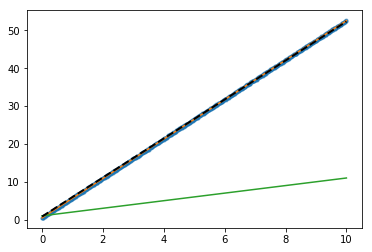

In [83]:
plt.plot(x, ys, '.', alpha=0.5)
plt.plot(x, y)
plt.plot(x, init[0] + init[1]*x)
plt.plot(x, fin[0] + fin[1]*x, 'k--', lw=2)


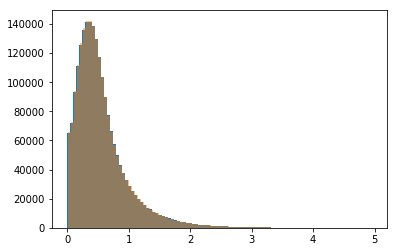

In [41]:
plt.hist(np.log(1+meshes[100][0]['cic'].flatten()), bins=100)
# ovd = (meshes[100][0]['cic'] - meshes[100][0]['cic'].mean())/meshes[100][0]['cic'].mean()
ovd = (meshes[100][0]['cic'] - meshes[100][0]['cic'].mean())/meshes[100][0]['cic'].mean()
plt.hist(np.log(1.01+ovd.flatten()), bins=100, alpha=0.5)

plt.show()